# PARALLEL IMPLEMENTATION ON THE SAMPLE SIZE OF 10000

In [23]:
%%file regression.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.size
from time import time


def Stochastic_Gradient_Descent(x, y, alpha, B):
    x = x * 1.0
    y = y * 1.0
    for i in range(0,len(x)):
        
        y_prediction = np.dot(B, x[i].T)     
        error = y_prediction - y[i]
        gradient = 2*(error)*B
        learning_rate =alpha
        
        B = B - ((learning_rate * gradient))
        
    return B


def cost_function(X, Y, B):
    m = len(Y)
    J = np.sum((X.dot(B) - Y) ** 2)/(2 * m)
    return J




data_samp= pd.read_csv("KDD_final.csv")

Start=MPI.Wtime()                         #CALCULATING START TIME AFTER DATA IS LOADED

ind = int(data_samp.shape[0] * .7)
train_X = data_samp[1:ind].drop(['TARGET_B', 'TARGET_D'], axis = 1)
train_y = data_samp.TARGET_D[1:ind]

test_X = data_samp[(ind + 1):-1].drop(['TARGET_B', 'TARGET_D'], axis = 1)
test_y = data_samp.TARGET_D[(ind + 1):-1]

x_i = np.array(train_X)
y_i = np.array(train_y)
length =int(len(x_i))
step = int(length//size)
assert len(x_i)==len(y_i)
Loss=[]

alpha = 0.0000005
max_itr= 150
np.random.seed(10)
time_epoch=[]
B1 = np.random.randint(1,2,size=((train_X.shape[1])))     

for i in range(max_itr):
     B1 = comm.bcast(B1,root=0) 
     Local_X = x_i[(rank)*step:(rank+1)*step]     
     Local_Y = y_i[(rank)*step:(rank+1)*step]
     W_collect=[]
     W = Stochastic_Gradient_Descent(Local_X, Local_Y, alpha, B1)   
     W_collect.append(W)   

     weight = comm.gather(W_collect,root=0 )   
     if rank ==0:
         B = np.mean(weight,axis = 0)  
         LOSS = cost_function(test_X,test_y, B[0])
         Loss.append(LOSS)
         Cost = Loss
         B1 = B[0] 
         B2 = B1
         End=MPI.Wtime()



try:
    print("Loss for",i,"number of iterations is:",Cost)
    print("\nWeight Matrix is",B2)
    Time= End-Start
    print("\nTime taken",Time,"secs for number of iterations:",i)
    #plt.plot(Cost)
    #plt.title('RMSE VS EPOCHS')
    #plt.xlabel('Number of Epochs')
    #plt.ylabel('Loss Calculated as RMSE')
    #plt.show()
except NameError:
    pass


Overwriting regression.py


In [21]:
!mpiexec -n 4 python regression.py

Loss for 149 number of iterations is: [161285.94024568453, 40507.78513726488, 18026.054092627517, 10143.894748795141, 6492.828748280253, 4508.871784490315, 3312.476553360277, 2535.98850542229, 2003.689802491639, 1623.004602470122, 1341.4007514737632, 1127.2705181068095, 960.6718456360888, 828.5191336938434, 721.9375419431706, 634.7359749492731, 562.4891061374419, 501.96586491629586, 450.76262560739644, 407.0614027552786, 369.4666365051024, 336.8926774219359, 308.4847404719521, 283.5624160355437, 261.5786709060506, 242.08966881461717, 224.73226648186895, 209.20703282352932, 195.26529485946082, 182.69915500097255, 171.33372563208874, 161.0210355464006, 151.63520922337162, 143.06862394564317, 135.22882449938894, 128.03602947826826, 121.4211030257316, 115.32389532958105, 109.69187720315067, 104.47901067348847, 99.64481008835736, 95.15355788377678, 90.97364657095618, 87.07702425231905, 83.43872546372378, 80.03647266261869, 76.85033646304024, 73.8624449262978, 71.05673397809669, 68.418732435

# SEQUENTIAL MODEL IN SKLEARN

In [47]:
import numpy as np
import pandas as pd
data_samp= pd.read_csv("KDD_final.csv")
ind = int(data_samp.shape[0] * .7)
train_X = data_samp[1:ind].drop(['TARGET_B', 'TARGET_D'], axis = 1)
train_y = data_samp.TARGET_D[1:ind]

test_X = data_samp[(ind + 1):-1].drop(['TARGET_B', 'TARGET_D'], axis = 1)
test_y = data_samp.TARGET_D[(ind + 1):-1]
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(train_X, train_y)

# Predicting the Test set results

Pred_y = regressor.predict(test_X)

def cost_function(Y, Y_pred):
    m = len(Y)
    J = np.sum((Y_pred - Y) ** 2)/(2 * m)
    return J

print("Loss for Sklearn Model is:",cost_function(test_y,Pred_y))


Loss for Sklearn Model is: 13.056489780789969


# PERFORMANCE ANALYSIS

In [30]:
!mpiexec -n 1 python regression.py


Time taken 99.10034034063574 secs for number of iterations: 99


In [31]:
!mpiexec -n 2 python regression.py


Time taken 57.1300091057783 secs for number of iterations: 99


In [32]:
!mpiexec -n 3 python regression.py


Time taken 55.357773924595676 secs for number of iterations: 99


In [33]:
!mpiexec -n 4 python regression.py


Time taken 50.33797099033836 secs for number of iterations: 99


In [34]:
!mpiexec -n 5 python regression.py


Time taken 49.23399517964572 secs for number of iterations: 99


In [35]:
!mpiexec -n 6 python regression.py


Time taken 50.523090309114195 secs for number of iterations: 99


In [36]:
!mpiexec -n 7 python regression.py


Time taken 49.803545495611615 secs for number of iterations: 99


<function matplotlib.pyplot.show(*args, **kw)>

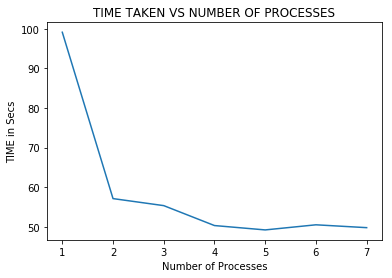

In [44]:
import matplotlib.pyplot as plt
TIME_TAKEN=[99.10,57.13,55.3577,50.33,49.23,50.52,49.80]
plt.plot([1,2,3,4,5,6,7],TIME_TAKEN)
plt.title('TIME TAKEN VS NUMBER OF PROCESSES')
plt.xlabel('Number of Processes')
plt.ylabel('TIME in Secs')
plt.show

In [5]:
Loss=[161285.94024568453, 40507.78513726488, 18026.054092627517, 10143.894748795141, 6492.828748280253, 4508.871784490315, 3312.476553360277, 2535.98850542229, 2003.689802491639, 1623.004602470122, 1341.4007514737632, 1127.2705181068095, 960.6718456360888, 828.5191336938434, 721.9375419431706, 634.7359749492731, 562.4891061374419, 501.96586491629586, 450.76262560739644, 407.0614027552786, 369.4666365051024, 336.8926774219359, 308.4847404719521, 283.5624160355437, 261.5786709060506, 242.08966881461717, 224.73226648186895, 209.20703282352932, 195.26529485946082, 182.69915500097255, 171.33372563208874, 161.0210355464006, 151.63520922337162, 143.06862394564317, 135.22882449938894, 128.03602947826826, 121.4211030257316, 115.32389532958105, 109.69187720315067, 104.47901067348847, 99.64481008835736, 95.15355788377678, 90.97364657095618, 87.07702425231905, 83.43872546372378, 80.03647266261869, 76.85033646304024, 73.8624449262978, 71.05673397809669, 68.41873243597831, 65.93537626965652, 63.59484763876822, 61.38643500204391, 59.30041120402336, 57.32792694715193, 55.46091747010039, 53.69202059424254, 52.01450458311738, 50.42220449491801, 48.90946590450063, 47.47109503584043, 46.10231448400674, 44.79872382211892, 43.55626448707845, 42.3711884211905, 41.24003001759788, 40.15958097772194, 39.12686774042071, 38.13913118665654, 37.19380836129546, 36.28851598617917, 35.42103556669864, 34.58929991828316, 33.79138096023524, 33.02547864251513, 32.289910886906924, 31.58310443777664, 30.90358652964538, 30.249977289319357, 29.620982799514852, 29.01538875898793, 28.432054681278313, 27.869908580414236, 27.327942097437308, 26.805206026457842, 26.300806203259256, 25.813899723267518, 25.343691459088113, 24.889430850801567, 24.450408944887457, 24.02595566000796, 23.61543726002049, 23.218254016459905, 22.833838044439553, 22.461651297423458, 22.101183707686857, 21.751951460497594, 21.413495391142803, 21.085379494914626, 20.767189541050698, 20.45853178242889, 20.159031753528758, 19.868333149833173, 19.586096782426626, 19.311999602077787, 19.04573378758554, 18.787005893593935, 18.535536053488663, 18.291057233348145, 18.05331453323908, 17.822064532465912, 17.597074675636485, 17.378122696664484, 17.16499607805704, 16.957491543037186, 16.75541457824441, 16.558578984926545, 16.366806456699432, 16.179926182092387, 15.997774470227705, 15.820194398115623, 15.647035478143131, 15.478153344453778, 15.313409456996066, 15.152670822117788, 14.995809728655177, 14.842703498542566, 14.693234251041199, 14.547288679737981, 14.40475784153578, 14.265536956903132, 14.129525220698303, 13.996625622940101, 13.866744778925247, 13.739792768146305, 13.615682981488067, 13.494331976223233, 13.375659338354128, 13.259587551880466, 13.146041874595275, 13.034950220042298, 12.926243045285284, 12.819853244167621, 12.715716045754997, 12.613768917677154, 12.51395147410051, 12.416205388079158, 12.320474308049748, 12.22670377824571, 12.13484116282325]

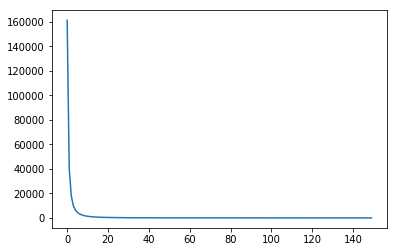

In [6]:
plt.plot(Loss)